![](https://vizwiz.org/wp-content/uploads/2019/05/logo-name1.png)

In the previous weeks, we got our Vizwiz data ready and trained and evaluated our LSTM-based models. 

In this week, we take a look at our model predictions and analyse them. 

We'll start by retraining our models, then identifying a few qualitative analysis strategies we can use to improve our VQA model.

The goal of this section is to engage students and make them understand how to analyse model performance and propose improvements.

In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }


### preparing definitions
# downloading and loading data
import gdown

# file variables
metadata_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/Annotations.zip'
metadata_path        = './metadata.zip'

###
gdown.download(metadata_url, './metadata.zip', True)
!unzip ./metadata.zip

# file variables
data_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/small.h5'
image_data_path      = 'small.h5'

###
gdown.download(data_url, 'small.h5', True)

# file variables
train_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/train.h5'
train_path      = 'train.h5'
###
gdown.download(train_url, 'train.h5', True)

# file variables
val_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/val.h5'
val_path      = 'val.h5'

###
gdown.download(val_url, 'val.h5', True)



# file variables
data_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/embedding_matrix.h5'
image_data_path      = 'embedding_matrix.h5'

###
gdown.download(data_url, 'embedding_matrix.h5', True)
embeddings_path = 'embedding_matrix.h5'



data_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/vocab_vizwiz%20(1).json'
image_data_path      = 'vocab.json'

###
gdown.download(data_url, 'vocab.json', True)
vocab_path = 'vocab.json'


import json
import random

def get_annotations(annotations_path):
    with open(annotations_path, 'r') as f:
      metadata = json.load(f)
    return metadata

def get_random_annotation(annotations_path):
    with open(annotations_path, 'r') as f:
      metadata = json.load(f)
    i = random.choice(range(len(metadata)))
    return metadata[i]

# getting data
annotations_path = './Annotations/val.json'
vocab_path = 'vocab.json'

def get_questions(annotations_path):
  
  with open(annotations_path, 'r') as f:
    annos = json.load(f)

  questions = set()
  for i in range(len(annos)):
    if annos[i]['answerable'] == 0:
      continue
    question = annos[i]['question']
    questions.add(question)

  return questions
  
from collections import Counter 
  
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

def get_answers(annotations_path):
  with open(annotations_path, 'r') as f:
    annos = json.load(f)
  answers = set()
  for i in range(len(annos)):
    if annos[i]['answerable'] == 0:
      continue
    ans = annos[i]['answers']
    answers_list = []
    for a in ans:
      answers_list += [a['answer']]
    answers.add(most_frequent(answers_list))
  return answers

def get_image_paths(annotations_path):
  with open(annotations_path, 'r') as f:
    annos = json.load(f)

  images = set()
  for i in range(len(annos)):
    if annos[i]['answerable'] == 0:
      continue
    image = annos[i]['image']
    images.add(image)

  return images

def parse_vocab(q, a):
  vocab = set()
  for qu in q:
    if '?' in qu:
      qu = qu.replace('?', '')

    vocab |= set(qu.split(' '))
  return vocab

## data and ploting
import h5py
import matplotlib.pyplot as plt

def get_data(path):
    data = h5py.File(path, 'r')
    images = data['images']
    image_idx = data['image_indices']
    questions = data['questions']
    answers = data['answers']
    return images, image_idx, questions, answers

def plot_image(img, questions=None, answers=None, indices=None):
    if indices is None:
      plt.imshow(img/255)
      plt.show()
    else:
      for i in indices:
        print('Question: ', questions[i])
        print('Answer: ', answers[i])
        plt.imshow(img[i]/255)
        plt.show()


Archive:  ./metadata.zip
   creating: Annotations/
  inflating: Annotations/val.json    
  inflating: Annotations/train.json  
  inflating: Annotations/test.json   



# Milestone 1. (Review) Training our VQA model


In [ ]:
#@title Run this to prepare our functions! { display-mode: "form" }


from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, LSTM, Flatten, Embedding, multiply
import h5py


#Taken from https://github.com/ranjaykrishna/iq with authorization from the author
# Make sure to read https://cs.stanford.edu/people/ranjaykrishna/iq/index.html if interested
import nltk
import re
import numpy as np
nltk.download('punkt')

class Vocabulary(object):

    def __init__(self):
        """Constructor for Vocabulary.
        """
        # Init mappings between words and ids
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.add_word('<pad>')
        self.add_word('<start>')
        self.add_word('<end>')
        self.add_word('<unk>')

    def add_word(self, word):
        if word not in self.word2idx:
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
          self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

    def save_vocab(self, location):
        with open(location, 'w') as f:
            json.dump({'word2idx': self.word2idx,
                       'idx2word': self.idx2word,
                       'idx': self.idx}, f)

    def load_vocab(self, location):
        with open(location, 'r') as f:
            data = json.load(f)
            self.word2idx = data['word2idx']
            self.idx2word = data['idx2word']
            self.idx = data['idx']

    def decode_sentence(self, tokens):
        words = []
        for token in tokens:
            word = self.idx2word[str(token)]
            if word == '<end>':
                break
            if word not in ['<pad>', '<start>', 
                            '<end>', '<unk>']:
                words.append(word)
        return ' '.join(words)

def load_vocab(vocab_path):
    vocab = Vocabulary()
    vocab.load_vocab(vocab_path)
    return vocab

def get_embeddings(path):
  matrix = h5py.File(path, 'r')
  return matrix['embedding_matrix'][()]

from keras.utils.np_utils import to_categorical

def prepare_data(data_path):
    data = h5py.File(data_path, 'r')

    questions = data['questions'][()]
    answers = to_categorical(data['answers'][()])
    return questions, answers

def encode_image(images_path, data_path):
  image_data = h5py.File(images_path, 'r')
  data = h5py.File(data_path, 'r')
  questions = data['questions'][()]
  image_features = image_data['feats'][()]
  answers = to_categorical(data['answers'][()])
  return image_features, questions, answers


#######

#@title Run this to download data and prepare our environment! { display-mode: "form" }


### preparing definitions
# downloading and loading data
import gdown
from keras.utils.np_utils import to_categorical


# file variables
train_feats_url         = 'https://drive.google.com/uc?id=1u485ehCP-ccAt3sSPwjCE0qCK-dOVsl5'
train_feats_path        = 'train_features.hdf5'

gdown.download(train_feats_url, 'train_features.hdf5', False)

# file variables

# file variables
val_feats_url         = 'https://drive.google.com/uc?id=1cdXPB49VuLr4ZbH-bwza9orlDddwDYOr'
val_feats_path        = 'val_features.hdf5'

gdown.download(val_feats_url, 'val_features.hdf5', False)



from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras import Input
from keras.layers.recurrent import LSTM
from keras.layers import concatenate

from keras.models import model_from_json, Model
from tensorflow.keras.utils import plot_model
from collections import defaultdict
import operator
from keras.utils import np_utils, generic_utils
from progressbar import Bar, ETA, Percentage, ProgressBar
from itertools import zip_longest
from keras.models import load_model

def image_model(hidden_size=512):
  image_model = Sequential()
  image_model.add(Reshape(input_shape = (4096,), target_shape=(4096,)))
  image_model.add(Dense(hidden_size, activation = 'tanh'))
  return image_model

def language_model(embedding, vocab_size, q_lengths = 20, 
                   num_layers = 2, hidden_size=512, 
                   embedding_size=100):

  language_model = Sequential()
  language_model.add(Embedding(vocab_size, embedding_size, 
                    weights=[embedding], input_length=q_lengths, 
                    trainable=False))
  language_model.add(LSTM(hidden_size, return_sequences=True, 
                          input_shape=(q_lengths, embedding_size)))
  for i in range(num_layers-2):
      language_model.add(LSTM(hidden_size, return_sequences=True))
  language_model.add(LSTM(hidden_size, return_sequences=False))

  return language_model

def vqa_model(embedding, vocab_size, q_lengths = 20, 
              num_lstm_layers = 2, hidden_size=512, 
              embedding_size=100, num_classes=30):
  image_model_ = image_model(hidden_size)

  language_model_ = language_model(embedding, vocab_size, 
                                   q_lengths = q_lengths, 
                                   num_layers = num_lstm_layers, 
                                   hidden_size=hidden_size, 
                                   embedding_size=embedding_size)
  
  combined = multiply([image_model_.output, language_model_.output])

  model = Dense(256, activation = 'tanh')(combined)
  model = Dropout(0.5)(model)

  model = Dense(256, activation = 'tanh')(model)
  model = Dropout(0.5)(model)

  model = Dense(128, activation = 'tanh')(model)
  model = Dropout(0.5)(model)

  model = Dense(num_classes)(model)
  model = Activation("softmax")(model)

  model = Model(inputs=[image_model_.input, language_model_.input], outputs=model)

  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  return model

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Downloading...
From: https://drive.google.com/uc?id=1u485ehCP-ccAt3sSPwjCE0qCK-dOVsl5
To: /content/train_features.hdf5
76.6MB [00:00, 209MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cdXPB49VuLr4ZbH-bwza9orlDddwDYOr
To: /content/val_features.hdf5
14.3MB [00:00, 176MB/s]


### Exercise (Coding):
In order to train our model, we first need to prepare our training data. We use the following function:

```image_features, questions, answers = encode_image(train_feats_path, train_path)```


In [ ]:
### YOUR CODE HERE
image_features, questions, answers = encode_image(train_feats_path, train_path)
### END CODE

In [ ]:
questions

array([[  1., 269., 278., ...,   0.,   0.,   0.],
       [  1., 749., 236., ...,   0.,   0.,   0.],
       [  1., 507., 119., ...,   0.,   0.,   0.],
       ...,
       [  1., 362., 160., ...,   0.,   0.,   0.],
       [  1., 749., 552., ...,   0.,   0.,   0.],
       [  1., 362., 631., ...,   0.,   0.,   0.]], dtype=float32)

We then need to load our vocab and get our embeddings.

To load our vocab, we use `vocab = load_vocab(vocab_path)`.

To get our embedding matrix, we use `embedding_matrix = get_embeddings(embeddings_path)`

In [ ]:
### YOUR CODE HERE
vocab = load_vocab(vocab_path)
embedding_matrix = get_embeddings(embeddings_path)
### END CODE

Now that we have our data ready, let's build our CNN-LSTM model.

In order to do so, we use 

`vqa_model = vqa_model(embedding_matrix, len(vocab), q_lengths = 20, 
          num_lstm_layers = 2, hidden_size=512, embedding_size=100,
          num_classes=30)`

In [ ]:
### YOUR CODE HERE
vqa_model = vqa_model(embedding_matrix, len(vocab), q_lengths = 20, num_lstm_layers = 2, hidden_size=512, embedding_size=100, num_classes=30)
### END CODE

After building our model, we can visualize our model architecture using:

`plot_model(vqa_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)`

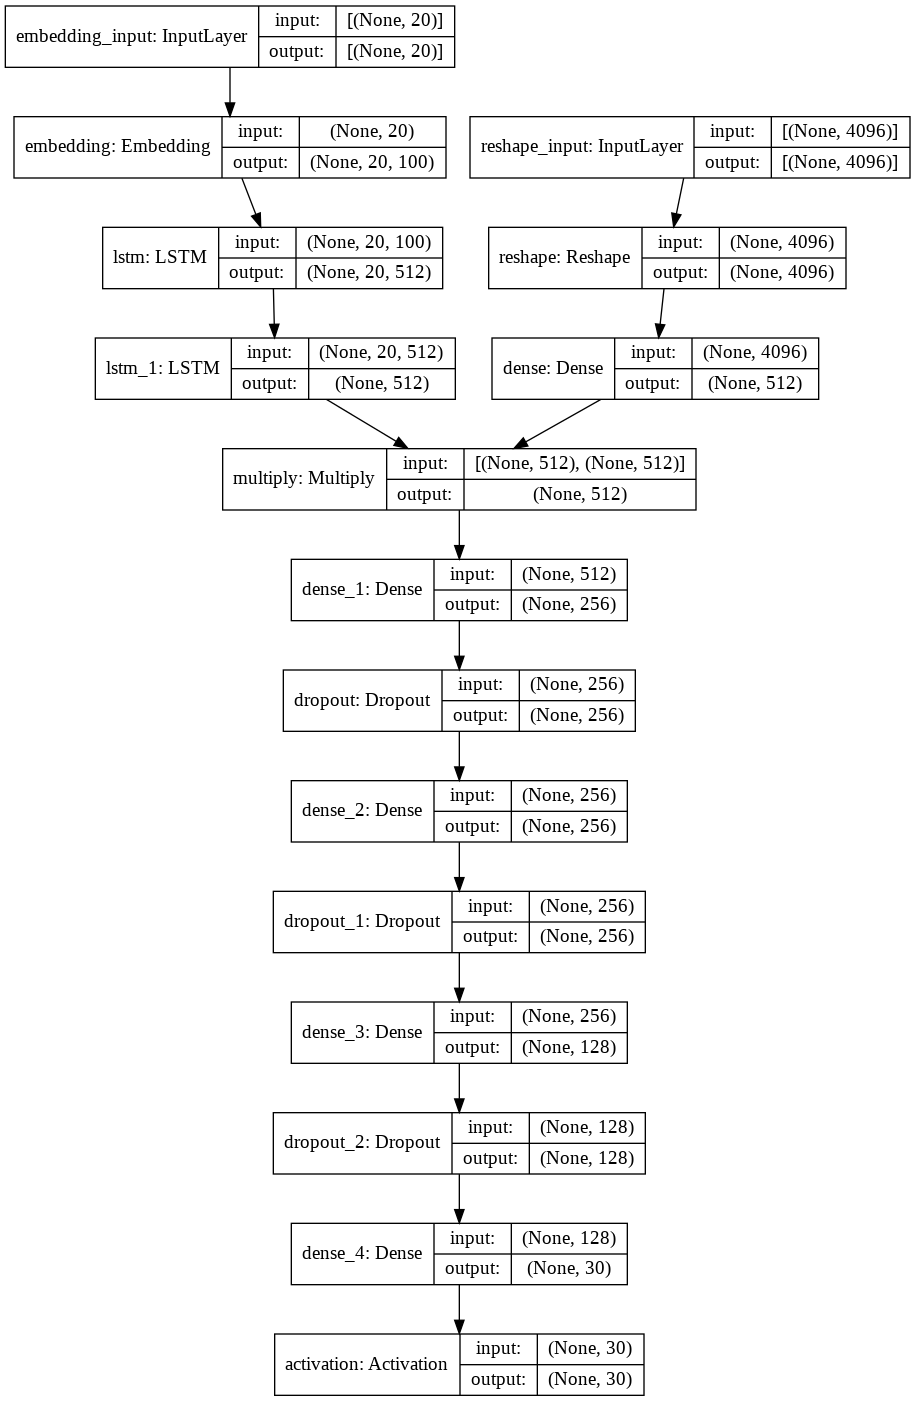

In [ ]:
### YOUR CODE HERE
plot_model(vqa_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
### END CODE

Let's now train our model. We use the following function:



> `vqa_model.fit([train_features, train_questions], train_answers, validation_data=([val_features, val_questions], val_answers),                 epochs=10, batch_size=64, shuffle=True)`


Make sure to load our validation data using:

> `val_features, val_questions, val_answers = encode_image(val_feats_path, val_path)`


In [ ]:
### YOUR CODE HERE
val_features, val_questions, val_answers = encode_image(val_feats_path, val_path)
vqa_model.fit([image_features, questions], answers, validation_data=([val_features, val_questions], val_answers), epochs=3, batch_size=64, shuffle=True)
### END CODE

Epoch 1/3
74/74 [==============================] - 44s 219ms/step - loss: 3.0404 - accuracy: 0.1826 - val_loss: 2.3521 - val_accuracy: 0.2345
Epoch 2/3
74/74 [==============================] - 15s 204ms/step - loss: 2.2054 - accuracy: 0.3521 - val_loss: 1.9984 - val_accuracy: 0.4034
Epoch 3/3
74/74 [==============================] - 16s 214ms/step - loss: 1.8540 - accuracy: 0.4455 - val_loss: 1.8339 - val_accuracy: 0.4230


### ***Discuss our model performance:*** 

What can we say about our model performance? 

Can we say we have solid performance?

Do you think our model can do better? 

Can we do better if we take a look at our train set answers statistics? 

Can we do better if we understand our model performance in our validation set?

### **Challenge exercise**: Make your own model

In this exercise, we provide you our own VQA model and challenge you to make it better.

**Warm up exercise:** Before we do so, we will first take a look at ways combining multi-modal vectors through 

the `np.concatenate()` function as well as the `np.multiply()` function.


 

Consider the following arrays `a` and `b`. 

In [ ]:
import numpy as np
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6]])

what are the shapes of our arrays?

In [ ]:
### YOUR CODE HERE
a.shape, b.shape
### END CODE

((2, 2), (1, 2))

Now, let's concatenate our arrays.
Use `np.concatenate((a, b), axis = 0)` and print the resulting array and its shape.

In [ ]:
### YOUR CODE HERE
print(np.concatenate((a,b), axis=0))
### END CODE

[[1 2]
 [3 4]
 [5 6]]


**Discussion:** `axis` can take the value 0, 1 and None. What does each value do?

Let's try to repeat the same exercise using `np.multiply(a,b)`.

In [ ]:
### YOUR CODE HERE
np.multiply(a,b)
### END CODE

array([[ 5, 12],
       [15, 24]])

**Warm up #2**: Let's build a tiny network for our VQA dataset.

Let's start with our language model and add an LSTM layer to our architecture.

We want our LSTM cell to have:


*   `hidden_size` as our hidden size
*   `return_sequences` to be equal to `True`

Hint: make sure to use the `.add()` function to add layers.



In [ ]:
def tiny_language_model(embedding, vocab_size, q_lengths = 20, 
                   num_layers = 2, hidden_size=512, 
                   embedding_size=100):

  language_model = Sequential()
  language_model.add(Embedding(vocab_size, embedding_size, 
                    weights=[embedding], input_length=q_lengths, 
                    trainable=False))
  ### YOUR CODE HERE
  language_model.add(LSTM(hidden_size, return_sequences=False))
  ### END CODE
  return language_model

Now Let's focus on our image model.

Make sure to add a Dense layer with the number of units equal to `hidden_size`.

In [ ]:
def tiny_image_model(hidden_size=512):
  image_model = Sequential()
  image_model.add(Reshape(input_shape = (4096,), target_shape=(4096,)))
  ### YOUR CODE HERE
  image_model.add(Dense(hidden_size, activation = 'tanh'))
  ### END CODE
  return image_model

Now, let's combine our model into one VQA model.

`combined = concatenate([image_model_.output, language_model_.output])`

`model = Dense(FILL_ME_IN, activation = 'tanh')(combined)`

`model = Dropout(FILL_ME_IN)(model)`

We can also use `multiply()` instead of `concatenate()` with the same parameters.

In [ ]:
def tiny_vqa_model(embedding, vocab_size, q_lengths = 20, 
              num_lstm_layers = 2, hidden_size=512, 
              embedding_size=100, num_classes=30):
  image_model_ = tiny_image_model(hidden_size)

  language_model_ = tiny_language_model(embedding, vocab_size, 
                                   q_lengths = q_lengths, 
                                   num_layers = num_lstm_layers, 
                                   hidden_size=512, 
                                   embedding_size=embedding_size)
  ### CHOOSE BETWEEN CONCATENATING OR MULTIPLYING LAYERS

  combined = concatenate([image_model_.output, language_model_.output], axis = -1)
  # combined = np.multiply([image_model_.output, language_model_.output])
  model = Dense(64, activation = 'tanh')(combined)
  model = Dropout(0.3)(model)

  ### END CODE

  model = Dense(num_classes)(model)
  model = Activation("softmax")(model)
  model = Model(inputs=[image_model_.input, language_model_.input], outputs=model)
  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  return model

Now, let's visualize and train our model.

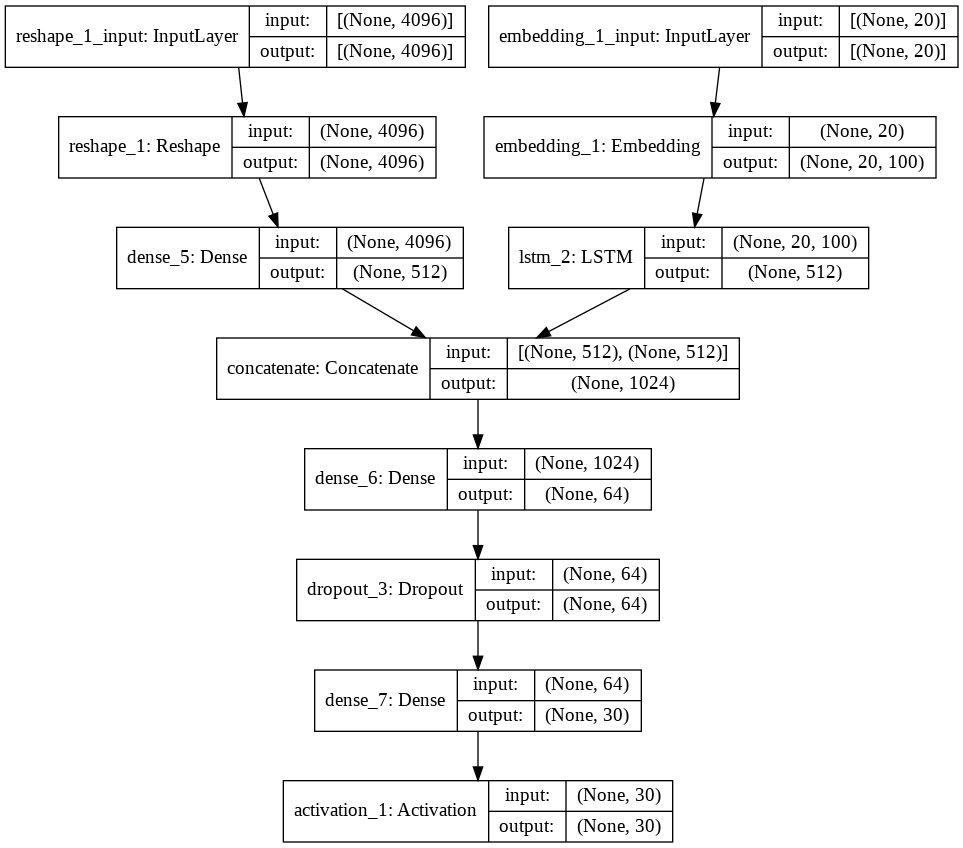

In [ ]:
tiny_vqa_model_ = tiny_vqa_model(embedding_matrix, len(vocab), q_lengths = 20, 
          num_lstm_layers = 2, hidden_size=512, embedding_size=100, num_classes=30)
plot_model(tiny_vqa_model_, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
val_features, val_questions, val_answers = encode_image(val_feats_path, val_path)
tiny_vqa_model_.fit([image_features, questions], answers, 
              validation_data=([val_features, val_questions], val_answers),
              epochs=3, batch_size=64, shuffle=True)

Epoch 1/3
74/74 [==============================] - 12s 115ms/step - loss: 2.8406 - accuracy: 0.2354 - val_loss: 1.9699 - val_accuracy: 0.4046
Epoch 2/3
74/74 [==============================] - 8s 106ms/step - loss: 1.7625 - accuracy: 0.4807 - val_loss: 1.6853 - val_accuracy: 0.4575
Epoch 3/3
74/74 [==============================] - 8s 107ms/step - loss: 1.4021 - accuracy: 0.5819 - val_loss: 1.6608 - val_accuracy: 0.4966


### Optional exercise: Better, more complex model

Make sure to add Dense layers with several layers, Dropout layers and any other layer types you might think would make the model better.

Here is our **image model**:

In [ ]:
def image_model(hidden_size=512):
  image_model = Sequential()
  image_model.add(Reshape(input_shape = (4096,), target_shape=(4096,)))
  ### YOUR CODE HERE
  image_model.add(Dense(256, activation = 'tanh'))
  image_model.add(Dropout(0.5))
  ### END CODE
  image_model.add(Dense(hidden_size, activation = 'tanh'))
  return image_model

def vqa_model(embedding, vocab_size, q_lengths = 20, 
              num_lstm_layers = 2, hidden_size=512, 
              embedding_size=100, num_classes=30):
  image_model_ = image_model(hidden_size)

  language_model_ = language_model(embedding, vocab_size, 
                                   q_lengths = q_lengths, 
                                   num_layers = num_lstm_layers, 
                                   hidden_size=hidden_size, 
                                   embedding_size=embedding_size)
  ### CHOOSE BETWEEN CONCATENATING OR MULTIPLYING LAYERS
  #combined = multiply([image_model_.output, language_model_.output])
  combined = concatenate([image_model_.output, language_model_.output])
  ### END CODE

  model = Dense(256, activation = 'tanh')(combined)
  model = Dropout(0.5)(model)
  
  ### YOUR CODE HERE: MAKE SURE TO ADD OR REMOVE LAYERS
  model = Dense(256, activation = 'tanh')(model)
  model = Dropout(0.5)(model)

  model = Dense(128, activation = 'tanh')(model)
  model = Dropout(0.5)(model)
  ### END CODE

  model = Dense(num_classes)(model)
  model = Activation("softmax")(model)

  model = Model(inputs=[image_model_.input, language_model_.input], outputs=model)

  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  return model

Here is what our model looks like. You can also choose different hyperparams!

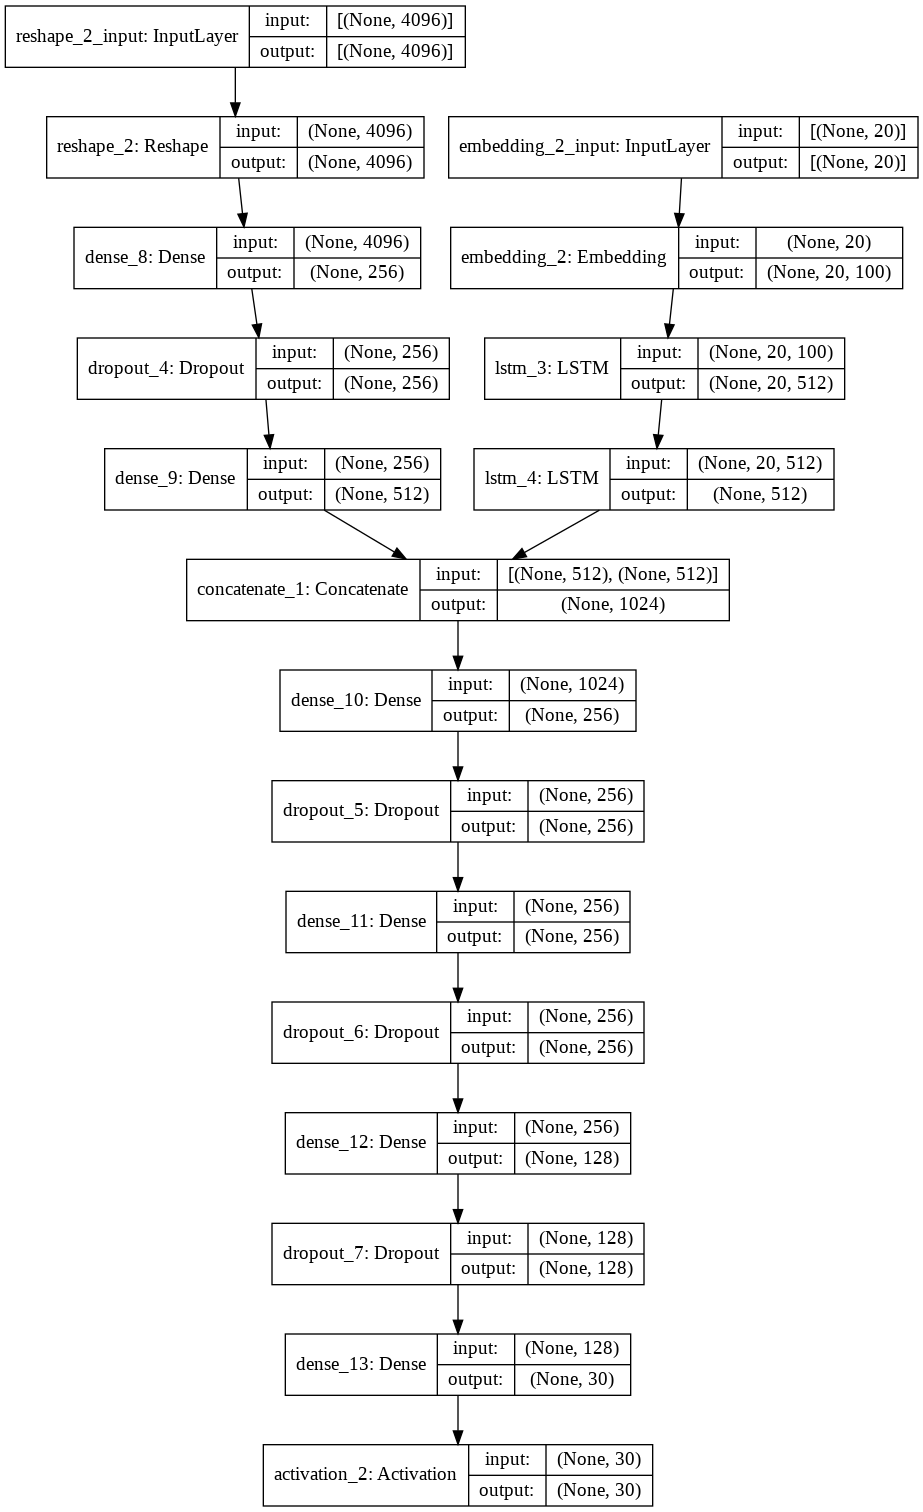

In [ ]:
vqa_model = vqa_model(embedding_matrix, len(vocab), q_lengths = 20, 
          num_lstm_layers = 2, hidden_size=512, embedding_size=100,
          num_classes=30)
plot_model(vqa_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Let's train our model.

Can you get a better model?

In [ ]:
val_features, val_questions, val_answers = encode_image(val_feats_path, val_path)
vqa_model.fit([image_features, questions], answers, 
              validation_data=([val_features, val_questions], val_answers),
              epochs=3, batch_size=64, shuffle=True)

Epoch 1/3
74/74 [==============================] - 23s 219ms/step - loss: 3.4874 - accuracy: 0.1165 - val_loss: 2.9460 - val_accuracy: 0.2598
Epoch 2/3
74/74 [==============================] - 15s 201ms/step - loss: 2.8627 - accuracy: 0.2341 - val_loss: 1.9669 - val_accuracy: 0.3805
Epoch 3/3
74/74 [==============================] - 15s 208ms/step - loss: 2.3226 - accuracy: 0.3246 - val_loss: 1.8960 - val_accuracy: 0.4276


# Milestone 2. Understanding our data



##Activity 2a. Our answer set

For our VQA task, we only use the top 30 answers in our dataset to train our model. 

We make sure to **ignore data points that are unanswerable** and assume a **setting where all question image pairs have an answer**. 

## Discussion: 
What the advantages and drawbacks of such an approach?


In [ ]:
#@title Run this to setup our environment! { display-mode: "form" }

### YOUR CODE HERE
import gdown
from collections import Counter

# file variables

filter_url         = 'https://drive.google.com/uc?id=1Jc4Nff-5oPrjc3dwdB4eI8NZjiWT1VTJ'
answers_list_path        = 'filter.json'

gdown.download(filter_url, 'filter.json', True)

def load_answer(path):
  return json.load(open(path, 'r'))

def data_stats(answers_data, answers_list):
  a = [answers_data[i].argmax() for i in range(answers_data.shape[0])]
  c = Counter(a)
  for i, cnt in c.items():
    print(answer_list[i],' : ', cnt, '(label %d)'%i)

  print('\n \n')

  answers_x = range(len(answer_list))
  a = [answers_data[i].argmax() for i in range(answers_data.shape[0])]
  c = Counter(a)
  freq = [0]*len(answers_x)
  for i, cnt in c.items():
    freq[i] = cnt

  LABELS = answer_list

  plt.bar(answers_x, freq, align='center')
  plt.show()

Let's take a look at our answer set.

Let's use the `answer_list = load_answer(answers_list_path)` function to load our answer list. 

Make sure to print our answers!

In [ ]:
### YOUR CODE HERE
answer_list = load_answer(answers_list_path)
print(answer_list)
### END CODE

['no', 'yes', 'white', 'grey', 'black', 'blue', 'red', 'pink', 'brown', 'green', 'keyboard', 'dog', 'soup', 'phone', 'purple', 'laptop', 'yellow', 'coffee', 'nothing', 'lotion', 'wine', 'food', 'tan', 'coca cola', 'shampoo', 'tv', 'corn', 'cell phone', 'orange', 'pepsi']


## Activity 2b. Train data

Let's take a look at our training set distribution.

In order to do so, use `data_stats(train_answers, answer_list)`.

coca cola  :  50 (label 23)
orange  :  46 (label 28)
yes  :  614 (label 1)
phone  :  71 (label 13)
white  :  369 (label 2)
no  :  1007 (label 0)
dog  :  79 (label 11)
lotion  :  67 (label 19)
food  :  58 (label 21)
red  :  191 (label 6)
grey  :  307 (label 3)
shampoo  :  68 (label 24)
nothing  :  150 (label 18)
pink  :  114 (label 7)
keyboard  :  96 (label 10)
tv  :  37 (label 25)
corn  :  48 (label 26)
pepsi  :  39 (label 29)
tan  :  41 (label 22)
blue  :  250 (label 5)
black  :  299 (label 4)
green  :  96 (label 9)
purple  :  72 (label 14)
soup  :  110 (label 12)
laptop  :  63 (label 15)
wine  :  57 (label 20)
coffee  :  57 (label 17)
yellow  :  59 (label 16)
brown  :  113 (label 8)
cell phone  :  46 (label 27)

 



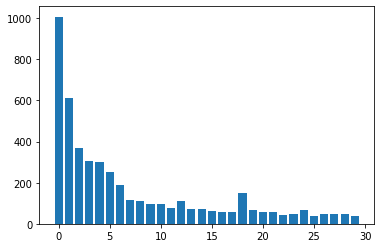

In [ ]:
### YOUR CODE HERE
data_stats(answers, answer_list)
### END CODE

### We have a heavy tail in our training data! 

### **Discuss**: Does this affect our training and model performance?

##Activity 2c. Validation data

Let's take a look at our validation set.

Use the same function from the previous activity. 

Make sure to use `val_answers` instead of `train_answers`.

nothing  :  37 (label 18)
white  :  76 (label 2)
yes  :  126 (label 1)
no  :  199 (label 0)
tv  :  9 (label 25)
blue  :  57 (label 5)
laptop  :  31 (label 15)
purple  :  12 (label 14)
red  :  25 (label 6)
soup  :  27 (label 12)
keyboard  :  21 (label 10)
phone  :  14 (label 13)
pink  :  20 (label 7)
yellow  :  9 (label 16)
lotion  :  12 (label 19)
pepsi  :  2 (label 29)
coffee  :  11 (label 17)
brown  :  19 (label 8)
wine  :  7 (label 20)
grey  :  38 (label 3)
dog  :  14 (label 11)
black  :  50 (label 4)
corn  :  7 (label 26)
cell phone  :  8 (label 27)
tan  :  2 (label 22)
orange  :  8 (label 28)
shampoo  :  7 (label 24)
green  :  7 (label 9)
food  :  9 (label 21)
coca cola  :  6 (label 23)

 



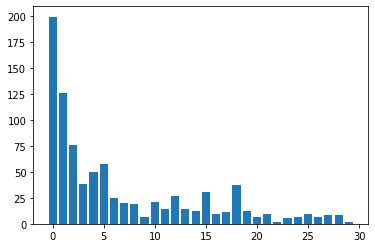

In [ ]:
### YOUR CODE HERE
data_stats(val_answers, answer_list)
### END CODE

### We can see that we have a mismatch in our training and validation data distributions! 

### **Discuss**: Does this affect our model performance?

# Milestone 3. Model performance: Predicted Answer Statistics

In [ ]:
#@title Run this to prepare functions and environment! { display-mode: "form" }

def get_categories():
  answer_categories = {"binary": ['no', 'yes'],
    "color": ['white', 'grey', 'black', 'blue', 'red', 'pink', 'brown', 'green', 'purple', 'yellow', 'tan', 'orange'], 
    "food": ['coffee', 'soup', 'wine', 'food', 'coca cola', 'corn', 'pepsi'],
    "object":['keyboard', 'phone', 'laptop', 'nothing', 'lotion', 'shampoo', 'tv','cell phone'],
    "animal": ['dog']
    }
  print("We have %d categories:"%len(answer_categories.keys()))
  for cat in answer_categories.keys():
    print(cat, ':', answer_categories[cat])
  return answer_categories

def get_pred(model, val_features, val_questions, val_answers, answer):
  if answer is None:
    for i in range(30):
      a_index = np.argwhere(np.argmax(val_answers, axis=1) == i).reshape(-1)
      y_pred = np.argmax(model.predict([val_features[a_index], val_questions[a_index]]), axis =1)
      accuracy = sum(np.argmax(val_answers, axis=1)[a_index] == y_pred) / len(a_index)
      print('we have an accuracy of %f for answer %s (tested on %d)'%(accuracy, answer_list[i], len(a_index)))
    from sklearn.metrics import classification_report
    y_pred = np.argmax(model.predict([val_features, val_questions]), axis =1)
    print(classification_report(np.argmax(val_answers, axis=1) , y_pred))
  else:
    a_index = np.argwhere(np.argmax(val_answers, axis=1) == answer).reshape(-1)
    y_pred =np.argmax(model.predict([val_features[a_index], val_questions[a_index]]), axis =1)
    accuracy = sum(np.argmax(val_answers, axis=1)[a_index] == y_pred) / len(a_index)
    print('we have an accuracy of %f for answer %s (tested on %d)'%(accuracy, answer_list[answer], len(a_index)))

# def get_prediction_stats(category, vqa_model, val_feats, val_questions, answers):
#   if answer is None:
#     for i in range(30):
#       a_index = np.argwhere(np.argmax(val_answers, axis=1) == i).reshape(-1)
#       y_pred = np.argmax(model.predict([val_features[a_index], val_questions[a_index]]), axis =1)
#       accuracy = sum(np.argmax(val_answers, axis=1)[a_index] == y_pred) / len(a_index)
#       print('we have an accuracy of %f for answer %s (tested on %d)'%(accuracy, answer_list[i], len(a_index)))
#     from sklearn.metrics import classification_report
#     y_pred = np.argmax(model.predict([val_features, val_questions]), axis =1)
#     print(classification_report(np.argmax(val_answers, axis=1) , y_pred))
#   else:
#     a_index = np.argwhere(np.argmax(val_answers, axis=1) == answer).reshape(-1)
#     y_pred =np.argmax(model.predict([val_features[a_index], val_questions[a_index]]), axis =1)
#     accuracy = sum(np.argmax(val_answers, axis=1)[a_index] == y_pred) / len(a_index)
#     print('we have an accuracy of %f for answer %s (tested on %d)'%(accuracy, answer_list[answer], len(a_index)))

def get_category_mapping(answers_list, answers_category):
  answer_map = {}
  for key in answers_category.keys():
    if not key in answer_map.keys():
      answer_map[key] = []
    answer_map[key] += [answers_list.index(ans) for ans in answer_categories[key]]
  return answer_map

def get_prediction_stats(category, model, val_feats, 
                         val_questions, answers_list, answers_category):
  answer_map = get_category_mapping(answers_list, answers_category)
  if category is None:
    for cat in answer_map.keys():
      a_index = []
      for c in answer_map[cat]:
        a_index += np.argwhere(np.argmax(val_answers, axis=1) == c).reshape(-1)
      y_pred = np.argmax(model.predict([val_features[a_index], val_questions[a_index]]), axis =1)
      accuracy = sum(np.argmax(val_answers, axis=1)[a_index] == y_pred) / len(a_index)
      print('\t We have an accuracy of %f for category %s (tested on %d)'%(accuracy, cat, len(a_index)))
  else:
    a_index = []
    for c in answer_map[category]:
      a_index += np.argwhere(np.argmax(val_answers, axis=1) == c).reshape(-1).tolist()
    y_pred = np.argmax(model.predict([val_features[a_index], val_questions[a_index]]), axis =1)
    accuracy = sum(np.argmax(val_answers, axis=1)[a_index] == y_pred) / len(a_index)
    print('We have an accuracy of %f for category %s (tested on %d)'%(accuracy, category, len(a_index)))


In [ ]:
#@title **Discussion:** Why is our model failing? { display-mode: "form" }

inputs = "Bad images" #@param ["Choose Answer","Bad images", "Confusing answers", "Confusing questions", "The model is not trained enough", "The model architecture is not good enough"]

if inputs == "Choose Answer":
  print("Please choose a valid answer!")
elif inputs == "Bad images":
  print("Could be a valid answer! However, we make sure to filter out our dataset to remove bad images.")
elif inputs == "Confusing questions":
  print("Could be a valid answer! We can check this out in our dataset!")
elif inputs == "The model is not trained enough":
  print("Make sure to retrain your model and finetune it")
elif inputs == "The model architecture is not good enough":
  print("(OUT OF THIS PROJECT SCOPE) We can try different architectures and see if we can do better.")
else:
  print("Could be a valid answer! However, we make sure to get the 30 most frequent answers so our answer range is not big enough to have confusing answers!")


Could be a valid answer! However, we make sure to filter out our dataset to remove bad images.


Let's do an **error analysis** of our model on our train and validation set!

## Activity 3a. Model performance per answer

###Exercise (Coding)

So far, we have evaluated our model on the whole train and validation sets and 
never looked at it in more details.

In this section, we take a closer look at our training and test set performance 
and examine our model's performance 

for each specific answer.



We start by choosing our answer of interest. We have around 30 answers, with labels ranging from 0 to 29. 

Make sure to choose one of them.

In [ ]:
answer = 1

If `answer = None` then we look at each answer prediction statistics.

We use `get_pred(model, val_features, val_questions, answer)` to get our model performance.

In [ ]:
### YOUR CODE HERE
get_pred(vqa_model, val_features, val_questions, val_answers, None)
### END CODE

we have an accuracy of 0.934673 for answer no (tested on 199)
we have an accuracy of 0.039683 for answer yes (tested on 126)
we have an accuracy of 0.684211 for answer white (tested on 76)
we have an accuracy of 0.236842 for answer grey (tested on 38)
we have an accuracy of 0.560000 for answer black (tested on 50)
we have an accuracy of 0.087719 for answer blue (tested on 57)
we have an accuracy of 0.560000 for answer red (tested on 25)
we have an accuracy of 0.000000 for answer pink (tested on 20)
we have an accuracy of 0.000000 for answer brown (tested on 19)
we have an accuracy of 0.000000 for answer green (tested on 7)
we have an accuracy of 0.809524 for answer keyboard (tested on 21)
we have an accuracy of 0.571429 for answer dog (tested on 14)
we have an accuracy of 0.888889 for answer soup (tested on 27)
we have an accuracy of 0.285714 for answer phone (tested on 14)
we have an accuracy of 0.000000 for answer purple (tested on 12)
we have an accuracy of 0.161290 for answer lapto

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Discussion:** What can you tell about our performance? Which answers need more work?

## Activity 3b. Model performance by answer category

### Exercise (Coding):


Let's split our answers into answer categories.

To do so, we use `answer_categories = get_categories()`

In [ ]:
### YOUR CODE HERE
answer_categories = get_categories()
### END CODE

We have 5 categories:
binary : ['no', 'yes']
color : ['white', 'grey', 'black', 'blue', 'red', 'pink', 'brown', 'green', 'purple', 'yellow', 'tan', 'orange']
food : ['coffee', 'soup', 'wine', 'food', 'coca cola', 'corn', 'pepsi']
object : ['keyboard', 'phone', 'laptop', 'nothing', 'lotion', 'shampoo', 'tv', 'cell phone']
animal : ['dog']


Now let's look at our model performance for each category.

To do so, we can specify one of the four categories we have and run `get_prediction_stats(category, vqa_model, val_feats, val_questions, answers)`.

if `category = None`, we show stats for all categories.

In [ ]:
category = 'object'
### YOUR CODE HERE
get_prediction_stats(category, vqa_model, val_features, val_questions, answer_list, answer_categories)
### END CODE

We have an accuracy of 0.251799 for category object (tested on 139)


### **Discussion:** Which category seems to be the best/worst?
In your opinion, why is our doing better in one category and not another?


## Activity 3c. Looking at our incorrect answers

In [ ]:
#@title Run this to prepare functions and environment! { display-mode: "form" }

### YOUR CODE HERE
def get_frequency(train_answers, X):
  a_index = np.argwhere(np.argmax(train_answers, axis=1) == X).reshape(-1)
  print("we have around %d answers"%len(a_index))


def get_stats(model, val_feats, val_questions, val_answers, X):
  a_index = np.argwhere(np.argmax(val_answers, axis=1) == X).reshape(-1)
  y_pred = np.argmax(model.predict([val_feats[a_index], val_questions[a_index]]), axis=1)
  accuracy = sum(np.argmax(val_answers, axis=1)[a_index] == y_pred) / len(a_index)
  print('\t We have an accuracy of %f for answer %d (tested on %d)'%(accuracy, X, len(a_index)))

def get_question_stats(train_questions, val_questions):
  train_idx, test_idx = [], []
  independent_train, independent_test = [], []
  for i, lst in enumerate(val_questions):
      if lst in train_questions:
          test_idx.append(i)
      else:
          independent_test.append(i)

  print("We have %d question in our validation set that the model has seen during training."%len(test_idx))
  return test_idx, independent_test

def print_bad_preds(model, vocab, val_features, val_questions, val_answers):
  y_pred = np.argmax(model.predict([val_features, val_questions]), axis=1)
  temp = np.argmax(val_answers, axis=1) == y_pred
  print(sum(temp))
  for i in range(len(temp)):
    if temp[i] == 0:
      print(vocab.decode_sentence(val_questions[i].astype(int)))
### END CODE

### ***Case study 1***: Looking at our performance for all questions with the answer `X`

#### Exercise (Coding):
Let's take a look at the frequency of answer `X` in our train set. In order to do so, we use the function `get_frequency(train_answers, X)`.


In [ ]:
X = 0
### YOUR CODE HERE
get_frequency(answers, X)
### END CODE

we have around 1007 answers


### **Discussion:** Can you say something from the start about how the frequency might affect our performance on this specific answer type?

Now let's take a look at our performance statistics on the validation set.

In order to do so, we use the function `get_stats(vqa_model, val_features, val_questions, val_answers, X)`

In [ ]:
### YOUR CODE HERE
get_stats(vqa_model, val_features, val_questions, val_answers, X)
### END CODE

	 We have an accuracy of 0.934673 for answer 0 (tested on 199)


### **Discussion:** What can you say about our validation performance?

Model seems to fail whenever the answer is `X`

Now let's do the same for our train set.

Use `get_stats(vqa_model, train_features, train_questions, train_answers, X)` to print our results.

In [ ]:
### YOUR CODE HERE
get_stats(vqa_model, image_features, questions, answers, X)
### END CODE

	 We have an accuracy of 0.948361 for answer 0 (tested on 1007)


### **Discussion:** Let's compare both results. What can you say about our model?

Is it overfitting? Is it even learning how to answer such questions? 

Can we say anything given our frequency?

### **Case study 2:** Looking at our questions stats

Let's now look at our questions. 

As we discussed earlier, some questions might be confusing to our model and this might affect its performance.

#### **Discussion:** What might be a confusing question?

> It might be a question that the model has never seen.

> It might be some gibberish

> It might have a lot of fillers that supposedly confuse our model.

Let's take a look at our train and validation set question intersection.

Use the `test_idx, independent_test = get_question_stat(train_questions, val_questions)` to get the number of unique and shared questions between our two sets.

In [ ]:
### YOUR CODE HERE
test_idx, independent_test = get_question_stats(questions, val_questions)
### END CODE

We have 870 question in our validation set that the model has seen during training.


So the model has seen all these questions before!

Maybe we can take a look at some questions and see if they are confusing or not.

Make sure to print a few questions and see if any questions are badly formatted.

Use `print_bad_preds(vqa_model, val_features, val_questions, val_answers)`

In [ ]:
### YOUR CODE HERE
print_bad_preds(vqa_model, vocab, val_features, val_questions, val_answers)
### END CODE

NameError: ignored

### **Discussion:** From what you have seen, can our question set quality affect our performance?

##**Ethics discussion**: Let's try to answer a few questions.

Is this an impactful project?

Are the proposed models efficient enough?

Are there any problems that might stem from such technology?

Any issues that might come from an irresponsible use of such technology?

# Fin! You just finished a cool impactful project!!


![](https://vizwiz.org/wp-content/uploads/2019/05/logo-name1.png)

NameError: ignored